In [ ]:
!pip install python-mnist

from mnist import MNIST
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import files

In [ ]:
files = ['t10k-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','t10k-labels-idx1-ubyte.gz','train-images-idx3-ubyte.gz']
for f in files:
    if not os.path.isfile(f):
        os.system(f'curl http://yann.lecun.com/exdb/mnist/{f} --output {f}')


In [ ]:
!gzip -d *
!ls

gzip: sample_data is a directory -- ignored
sample_data		t10k-labels-idx1-ubyte	 train-labels-idx1-ubyte
t10k-images-idx3-ubyte	train-images-idx3-ubyte


In [ ]:
class Activation:
    @staticmethod
    def sigmoid(z,derivative=False):
        if derivative:
            return z * (1 - z)
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def softmax(z):
        return np.exp(z) / np.exp(z).sum()

In [ ]:
class Normalize:
    @staticmethod
    def minmax(X):
        X = np.array(X)
        return (X - X.min()) / (X.max() - X.min())
        
    @staticmethod
    def std(X):
        X = np.array(X)
        return (X - X.mean()) / X.std()

In [ ]:
class Data:
    def __init__(self,train_x,train_y,test_x=None,test_y=None):
        [self.init_train_x,self.init_train_y] = [train_x,train_y]
        [self.train_x,self.train_y] = [np.array(train_x),np.array(train_y)]
        [self.test_x,self.test_y] = [np.array(test_x),np.array(test_y)]

        self.m = len(train_x)
        self.m1 = len(test_x)
        self.x_len = len(train_x[0])
        self.classes = len(set(train_y))
        self.mini_batch = False
        self.ohe = False
        self.k = self.m

    def create_batches(self,k):
        if not self.mini_batch:
            self.mini_batch = True
            self.k = k
            self.batch_size = int(self.m / self.k)
            self.train_x = self.train_x.reshape((k,self.batch_size,self.x_len))
            self.train_y = self.train_y.reshape((k,self.batch_size,self.classes if self.ohe else 1))
        else:
            raise Exception('Batches are already created')
    
    def use_ohe(self):
        if self.mini_batch:
            new_y = np.zeros((self.k,self.batch_size,self.classes))
            for i,batch_y in enumerate(self.train_y):
                for j,y in enumerate(batch_y):
                    new_y[i][j][y] = 1
            self.train_y = new_y
        else:
            new_y = np.zeros((self.m,self.classes))
            for i,y in enumerate(self.train_y):
                new_y[i][y] = 1
            self.train_y = new_y
        self.ohe = True

In [ ]:
class Model:
    def __init__(self,layers,data):
        self.layers = layers
        self.L = len(layers) - 1
        self.data = data
        self.r = 1e-2
        self.n_epochs = 0
        self.cum_epochs = 0     # Cumulative epochs
        self.cost_hist = []
        self.grad_hist = []
        self.train_acc = []
        self.test_acc = []
        
        # Initialize nodes and deltas
        self.A = [np.ones((s + int(l < self.L),1),dtype=np.float128) for l,s in enumerate(layers)]
        self.D = self.A.copy()
        
        # Initialize weights with Xavier initialization
        self.T = []
        for i,l in enumerate(layers[:-1]):
            eps = np.sqrt(6) / np.sqrt(l + layers[i + 1])
            thetaVec = np.random.uniform(low=-eps,high=eps,size=(layers[i + 1],l + 1))
            thetaVec.dtype = np.float64
            self.T.append(thetaVec)
        
        self.G = self.T.copy()

    def __log_loss(self,y):
        if self.data.ohe:
            y = y.reshape(y.size,1)

        return (y * np.log(self.A[self.L]) + (1 - y) * np.log(1 - self.A[self.L])).sum()

    def feedforward(self,x,eps=0):
        self.A[0][1:] = x.reshape(self.data.x_len,1)
        for l in range(self.L):
            self.A[l + 1][int(l < self.L - 1):] = Activation.sigmoid((self.T[l] + eps) @ self.A[l]) if l < self.L - 1 else Activation.softmax((self.T[l] + eps) @ self.A[l])
        

    def calc_error(self,y):
        for l in range(self.L,0,-1):
            if l == self.L:
                self.D[l] = self.A[l] - y
            else:
                self.D[l] = (self.T[l].T @ self.D[l + 1][int(l < self.L - 1):]) * Activation.sigmoid(self.A[l],True)
                self.D[l][0] = self.D[l + 1].sum()
    

    def J(self,loss,r,eps = 0):
        thetaSum = sum([(self.T[l] + eps).sum() ** 2 for l in range(self.L - 1)])
        return (-1 / self.data.k) * loss + (r / (2 * self.data.k)) * thetaSum
    

    def check_gradient(self,x,y,eps):
        self.feedforward(x,eps)
        loss1 = self.__log_loss(y)
        j_plus = self.J(loss1,self.r,eps)

        self.feedforward(x,-eps)
        loss2 = self.__log_loss(y)
        j_minus = self.J(loss2,self.r,eps)

        return (j_plus - j_minus) / (2 * eps)


    def update_weights(self,r):
        rVec = self.T.copy()
        rSum = []
        for x in range(len(rVec)):
            rVec[x][:,0] = 0
            rSum.append(rVec[x].sum())
        rSum = sum(rSum)
            
        for l in range(self.L - 1):
            self.T[l] -= (self.lr / self.data.k) * (self.A[l] @ self.D[l + 1][int(l < self.L - 1):].T).T + (r * rSum)

    
    def lr_decay(self,rate):
        self.lr *= rate ** np.sqrt(self.cum_epochs)
        


    def train(self,lr,r,decay_rate=1,epochs=10,check_grad=False,calc_cost=False,eps=0,accuracy_threshold=1.5):
        self.lr = lr
        self.r = r
        self.n_epochs = 0

        while self.n_epochs < epochs:
            print(f"=====================================================")
            print(f"(Epoch {self.n_epochs})")
            print(f"Cumulative epochs: {self.cum_epochs}")
            self.update_accuracy()
            loss = 0
            for batch_x,batch_y in zip(self.data.train_x,self.data.train_y):
                for x,y in zip(batch_x,batch_y):
                    self.feedforward(x,eps)
                    self.calc_error(y if not self.data.ohe else y.reshape(self.data.classes,1))
                    self.update_weights(r)

                    if calc_cost:
                        loss += self.__log_loss(y)
                
                if calc_cost:
                    self.cost_hist.append(self.J(loss,r,eps))
                if check_grad:
                    self.grad_hist.append(self.check_gradient(x,y,eps))
            accuracy_diff = abs(self.train_acc[-1] - self.test_acc[-1])
            if accuracy_diff >= accuracy_threshold:
                return

            self.update_accuracy()
            print(f"Training accuracy: {self.train_acc[-1]}\nTest accuracy: {self.test_acc[-1]}")
            print(f"=====================================================\n")
                
            self.n_epochs += 1
            self.cum_epochs += 1
            self.lr_decay(decay_rate)   

    def predict(self,x,y,show_output=False):
        self.feedforward(x)

        if type(y) == np.ndarray:
            return [np.argmax(self.A[self.L]).sum(),np.argmax(y)]
        else:
            return [np.argmax(self.A[self.L]).sum(),y]
            
    
    def update_accuracy(self):
        train = np.zeros(10)
        for x,y in zip(self.data.init_train_x,self.data.init_train_y):
            [output,expected] = self.predict(x,y)
            if output == expected:
                train[output] += 1
        self.train_acc.append(sum(train) / self.data.m * 100)

        test = np.zeros(10)
        for x,y in zip(self.data.test_x,self.data.test_y):
            [output,expected] = self.predict(x,y)
            if output == expected:
                test[output] += 1
        self.test_acc.append(sum(test) / self.data.m1 * 100)


    def summary(self):
        text = f"Epochs: {self.n_epochs}\nTotal epochs: {self.cum_epochs}\nLearning rate: {nn.lr}\nTraining accuracy: {self.train_acc[-1]}\nTest accuracy: {self.test_acc[-1]}"
        print(text)
        if len(self.cost_hist) > 0:
            print(f"Cost: {self.cost_hist[-1]}")
        if len(self.grad_hist) > 0:
            print(f"Gradient: {self.grad_hist[-1]}")


# **MNIST Dataset Optical Character Recognition**
_As the documentation will not cover the concepts of the neural network, please find the simpler version of ANN [here](https://github.com/dandycheng/ml-simple-xnor-neural-network/)._

---

## **Configuration**

### **Layers**
>Input layer: $(784\times1)$<br>
Hidden layer 1: $(80\times1)$<br>
Output layer: $(10\times1)$

### **Activation functions**
>Hidden layer 1: Sigmoid<br>
Output layer: Softmax

### **Hyperparameters**
>Learning rate: $1e-5$ to $1.5$<br>
Regularization: $3e-5$<br>
Batches: $10$\
Learning rate decay: $1$ _(Constant learning rate)_

### **Learning rate decay**
>$\alpha:=\gamma^{\sqrt{epochs}}\alpha$, where $\alpha$ is the learning rate, and $\gamma$ is the decay rate

### **Weight initialization**
>$\sum_{l=1}^{L - 1}\pm\frac{\sqrt{6}}{\sqrt{S_l} + \sqrt{S_{l + 1}}}$, where $L$ is the output layer, and $S_l$ is the number of nodes in layer $l$

### **Normalization**
>For all training example $(x^{(t)},y^{(t)})$, all $x^{(t)}$ were normalized using minmax:<br>
$x^{(t)}:=\frac{x - x_{min}}{x_{max} - x_{min}}$


---

With these configurations, it is possible to obtain a training and test accuracy of $92\% - 94\%$ with $14$ epochs.

In [ ]:
data = MNIST('.')
train_images, train_labels = data.load_training()
test_images, test_labels = data.load_testing()

train_x = Normalize.minmax(train_images)
test_x = Normalize.minmax(test_images)

In [ ]:
dataset = Data(train_x,train_labels,test_x,test_labels)
dataset.create_batches(10)
dataset.use_ohe()

nn = Model([784,70,10],dataset)

In [ ]:
nn.train(2,3e-5,decay_rate=1,epochs=5,check_grad=True,calc_cost=True,eps=1e-4,accuracy_threshold=0.5)

(Epoch 0)
Cumulative epochs: 6
Training accuracy: 92.71666666666667
Test accuracy: 92.62

(Epoch 1)
Cumulative epochs: 7
Training accuracy: 92.785
Test accuracy: 92.64

(Epoch 2)
Cumulative epochs: 8
Training accuracy: 92.81666666666666
Test accuracy: 92.67999999999999

(Epoch 3)
Cumulative epochs: 9
Training accuracy: 92.83333333333333
Test accuracy: 92.69

(Epoch 4)
Cumulative epochs: 10
Training accuracy: 92.84
Test accuracy: 92.72



Epochs: 5
Total epochs: 11
Learning rate: 0.01
Training accuracy: 92.84
Test accuracy: 92.72
Cost: 4479.273880135781
Gradient: -0.004226910548608473


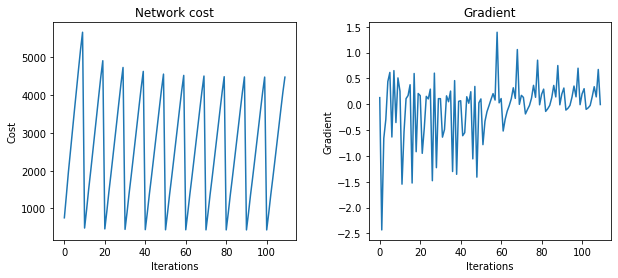

In [ ]:
nn.summary()
x_axis = [nn.cost_hist,nn.grad_hist]
y_label = ["Cost","Gradient"]
title = ["Network cost","Gradient"]

fig = plt.figure(figsize=(10,4))
for i,y in enumerate(y_label):
    fig.subplots_adjust(wspace=0.3)
    fig.add_subplot(1,2,i + 1)
    plt.xlabel("Iterations")
    plt.ylabel(y)
    plt.title(title[i])
    plt.plot(x_axis[i])

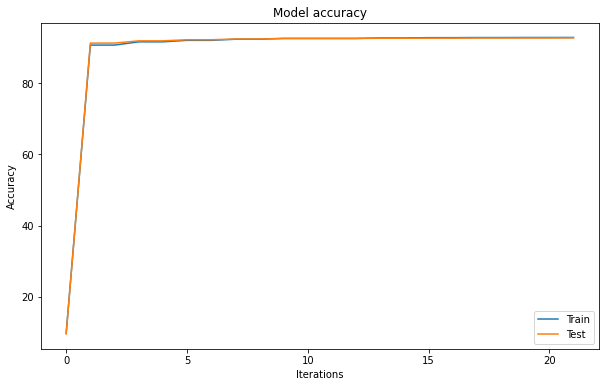

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Model accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(nn.train_acc,label="Train")
plt.plot(nn.test_acc,label="Test")
plt.legend(loc="lower right")
plt.show()

Now we take a test image and pass it into the neural network. In this example, we take the number $7$.

To predict a number, we take the following steps:

1. Normalize input. In this case, we use $minmax$
2. Feed it to the neural network by using ```nn.predict()```
3. The ```predict()``` function will return the predicted number by utilizing the $softmax$ function.

Predicted number: 7
Actual number: 7
Output layer
[[0.00870439]
 [0.00528639]
 [0.00671943]
 [0.01977806]
 [0.00428522]
 [0.00609562]
 [0.00858216]
 [0.92023741]
 [0.00695449]
 [0.01335683]]


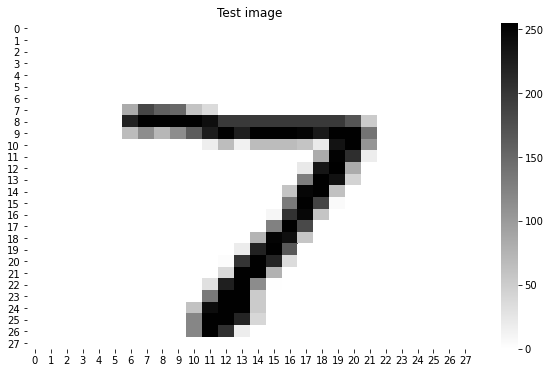

In [ ]:
test_image_1 = np.array(test_images[0]).reshape(28,28)
test_label_1 = test_labels[0]

[predicted,actual] = nn.predict(Normalize.minmax(test_image_1),test_label_1)
print(f"Predicted number: {predicted}\nActual number: {actual}")
print(f"Output layer\n{nn.A[nn.L]}")
plt.figure(figsize=(10,6))
plt.title('Test image')
sns.heatmap(test_image_1,cmap='gray_r')
plt.show()